<a href="https://colab.research.google.com/github/Garimakushh/Traffic-speed-prediction/blob/main/trafficMergedWeather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import h5py

# Function to load raw data from HDF5
def load_data(file_path, group_name):
    with h5py.File(file_path, "r") as f:
        return np.array(f[group_name]["block0_values"])

# Function to convert loaded data to DataFrame with timestamps
def to_dataframe(data, sensors, start_date):
    timestamps = pd.date_range(start=start_date, periods=data.shape[0], freq="5min")
    return pd.DataFrame(data, index=timestamps, columns=[f"sensor_{i}" for i in range(sensors)])

# ======== Load METR-LA Dataset ========
metrla_path = "/content/drive/MyDrive/M_project/metr-la.h5"
metrla_raw = load_data(metrla_path, "df")
metrla_df = to_dataframe(metrla_raw, metrla_raw.shape[1], "2012-03-01")

# ======== Load PEMS-BAY Dataset ========
pemsbay_path = "/content/drive/MyDrive/M_project/pems-bay.h5"
pemsbay_raw = load_data(pemsbay_path, "speed")
pemsbay_df = to_dataframe(pemsbay_raw, pemsbay_raw.shape[1], "2017-01-01")

# ======== Output Info ========
print(" METR-LA loaded. Shape:", metrla_df.shape)
print(metrla_df.head())

print("\n PEMS-BAY loaded. Shape:", pemsbay_df.shape)
print(pemsbay_df.head())


 METR-LA loaded. Shape: (34272, 207)
                      sensor_0   sensor_1   sensor_2   sensor_3   sensor_4  \
2012-03-01 00:00:00  64.375000  67.625000  67.125000  61.500000  66.875000   
2012-03-01 00:05:00  62.666667  68.555556  65.444444  62.444444  64.444444   
2012-03-01 00:10:00  64.000000  63.750000  60.000000  59.000000  66.500000   
2012-03-01 00:15:00   0.000000   0.000000   0.000000   0.000000   0.000000   
2012-03-01 00:20:00   0.000000   0.000000   0.000000   0.000000   0.000000   

                      sensor_5  sensor_6  sensor_7   sensor_8   sensor_9  ...  \
2012-03-01 00:00:00  68.750000    65.125    67.125  59.625000  62.750000  ...   
2012-03-01 00:05:00  68.111111    65.000    65.000  57.444444  63.333333  ...   
2012-03-01 00:10:00  66.250000    64.500    64.250  63.875000  65.375000  ...   
2012-03-01 00:15:00   0.000000     0.000     0.000   0.000000   0.000000  ...   
2012-03-01 00:20:00   0.000000     0.000     0.000   0.000000   0.000000  ...   

       

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import requests
import time

# === Configuration ===
data_path = '/content/drive/MyDrive'
api_key = '00eaf60012be43799a60c8b67a81f171'
weatherbit_url = "https://api.weatherbit.io/v2.0/history/hourly"

# === Load processed METR-LA dataset ===
metr_la = pd.read_hdf(f"{data_path}/M_project/metr-la.h5")
metr_la.index = pd.to_datetime(metr_la.index, errors='coerce')
metr_la = metr_la[metr_la.index.notnull()]
metrla_start = metr_la.index.min()
metrla_end = metr_la.index.max()

# === Function to fetch 6-hour weather data ===
def fetch_sixhr_weather(start_time, lat, lon, api_key):
    end_time = start_time + timedelta(hours=6)
    params = {
        'lat': lat,
        'lon': lon,
        'start_date': start_time.strftime('%Y-%m-%d:%H'),
        'end_date': end_time.strftime('%Y-%m-%d:%H'),
        'key': api_key,
        'units': 'M'
    }
    try:
        r = requests.get(weatherbit_url, params=params)
        if r.status_code == 200:
            return r.json().get("data", [])
        else:
            print(f" Error: {r.status_code} - {r.text}")
            return []
    except Exception as e:
        print(" Exception:", e)
        return []

# === Fetch & aggregate weather data ===
def fetch_weather_series(start_ts, end_ts, lat, lon, api_key, city_tag):
    print(f"\n🌦 Fetching weather for {city_tag} from {start_ts} to {end_ts}...\n")
    current = start_ts
    all_weather = []

    while current <= end_ts:
        print(f"📆 {city_tag} | Fetching: {current} to {current + timedelta(hours=6)}")
        hourly_data = fetch_sixhr_weather(current, lat, lon, api_key)
        all_weather.extend(hourly_data)
        time.sleep(1)  # prevent API rate limiting
        current += timedelta(hours=6)

    # Convert to DataFrame
    weather_df = pd.DataFrame(all_weather)
    if 'timestamp_utc' in weather_df.columns:
        weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp_utc'])
        weather_df['timestamp'] = weather_df['timestamp'].dt.floor('6h')  # Align to 6H

        # Keep only numeric columns
        numeric_cols = weather_df.select_dtypes(include='number').columns.tolist()
        weather_df = weather_df[['timestamp'] + numeric_cols]

        # Average over 6-hour blocks
        weather_df = weather_df.groupby('timestamp').mean().reset_index()

    return weather_df

# === Fetch METR-LA Weather ===
metrla_weather = fetch_weather_series(
    start_ts=metrla_start,
    end_ts=metrla_end,
    lat=34.0522, lon=-118.2437,
    api_key=api_key,
    city_tag="METR-LA"
)




🌦 Fetching weather for METR-LA from 2012-03-01 00:00:00 to 2012-06-27 23:55:00...

📆 METR-LA | Fetching: 2012-03-01 00:00:00 to 2012-03-01 06:00:00
📆 METR-LA | Fetching: 2012-03-01 06:00:00 to 2012-03-01 12:00:00
📆 METR-LA | Fetching: 2012-03-01 12:00:00 to 2012-03-01 18:00:00
📆 METR-LA | Fetching: 2012-03-01 18:00:00 to 2012-03-02 00:00:00
📆 METR-LA | Fetching: 2012-03-02 00:00:00 to 2012-03-02 06:00:00
📆 METR-LA | Fetching: 2012-03-02 06:00:00 to 2012-03-02 12:00:00
📆 METR-LA | Fetching: 2012-03-02 12:00:00 to 2012-03-02 18:00:00
📆 METR-LA | Fetching: 2012-03-02 18:00:00 to 2012-03-03 00:00:00
📆 METR-LA | Fetching: 2012-03-03 00:00:00 to 2012-03-03 06:00:00
📆 METR-LA | Fetching: 2012-03-03 06:00:00 to 2012-03-03 12:00:00
📆 METR-LA | Fetching: 2012-03-03 12:00:00 to 2012-03-03 18:00:00
📆 METR-LA | Fetching: 2012-03-03 18:00:00 to 2012-03-04 00:00:00
📆 METR-LA | Fetching: 2012-03-04 00:00:00 to 2012-03-04 06:00:00
📆 METR-LA | Fetching: 2012-03-04 06:00:00 to 2012-03-04 12:00:00
📆 METR

In [ ]:
print(metrla_weather.head())
print(metrla_weather.columns)


                      app_temp     azimuth     clouds     dewpt        dhi  \
2012-03-01 00:00:00  13.183333  267.516667  97.666667  8.566667  21.833333   
2012-03-01 00:05:00  13.163194  266.429398  97.594907  8.590046  21.530093   
2012-03-01 00:10:00  13.143056  265.342130  97.523148  8.613426  21.226852   
2012-03-01 00:15:00  13.122917  264.254861  97.451389  8.636806  20.923611   
2012-03-01 00:20:00  13.102778  263.167593  97.379630  8.660185  20.620370   

                            dni  elev_angle        ghi  precip         pres  \
2012-03-01 00:00:00  192.333333   -9.350000  72.500000     0.0  1009.000000   
2012-03-01 00:05:00  189.662037   -9.979861  71.493056     0.0  1008.993056   
2012-03-01 00:10:00  186.990741  -10.609722  70.486111     0.0  1008.986111   
2012-03-01 00:15:00  184.319444  -11.239583  69.479167     0.0  1008.979167   
2012-03-01 00:20:00  181.648148  -11.869444  68.472222     0.0  1008.972222   

                     ...          slp  snow  solar_rad  

In [ ]:
# If your timestamp is the index, reset it and rename
metrla_weather = metrla_weather.reset_index()
metrla_weather.rename(columns={'index': 'timestamp'}, inplace=True)


In [ ]:
print(metrla_weather.head())
print(metrla_weather.columns)

            timestamp   app_temp     azimuth     clouds     dewpt        dhi  \
0 2012-03-01 00:00:00  13.183333  267.516667  97.666667  8.566667  21.833333   
1 2012-03-01 00:05:00  13.163194  266.429398  97.594907  8.590046  21.530093   
2 2012-03-01 00:10:00  13.143056  265.342130  97.523148  8.613426  21.226852   
3 2012-03-01 00:15:00  13.122917  264.254861  97.451389  8.636806  20.923611   
4 2012-03-01 00:20:00  13.102778  263.167593  97.379630  8.660185  20.620370   

          dni  elev_angle        ghi  precip  ...          slp  snow  \
0  192.333333   -9.350000  72.500000     0.0  ...  1022.000000   0.0   
1  189.662037   -9.979861  71.493056     0.0  ...  1021.993056   0.0   
2  186.990741  -10.609722  70.486111     0.0  ...  1021.986111   0.0   
3  184.319444  -11.239583  69.479167     0.0  ...  1021.979167   0.0   
4  181.648148  -11.869444  68.472222     0.0  ...  1021.972222   0.0   

   solar_rad       temp            ts        uv        vis    wind_dir  \
0  29.166667

In [ ]:
# Save as CSV
metrla_weather.to_csv(f"{data_path}/M_project/metrla_wther.csv", index=False)
print("Saved METR-LA weather data as CSV.")

# Save as HDF5
metrla_weather.to_hdf(f"{data_path}/M_project/metrla_wther.h5", key='weather', mode='w')
print("Saved METR-LA weather data as HDF5.")

Saved METR-LA weather data as CSV.
Saved METR-LA weather data as HDF5.


In [ ]:
# Make sure timestamp is a column, not an index
metr_la = metr_la.reset_index()  # Only do this if timestamp is the index


In [ ]:
print(metr_la.columns)
print(metrla_weather.columns)


Index(['index', '773869', '767541', '767542', '717447', '717446', '717445',
       '773062', '767620', '737529',
       ...
       '772167', '769372', '774204', '769806', '717590', '717592', '717595',
       '772168', '718141', '769373'],
      dtype='object', length=208)
Index(['timestamp', 'app_temp', 'azimuth', 'clouds', 'dewpt', 'dhi', 'dni',
       'elev_angle', 'ghi', 'precip', 'pres', 'rh', 'slp', 'snow', 'solar_rad',
       'temp', 'ts', 'uv', 'vis', 'wind_dir', 'wind_gust_spd', 'wind_spd'],
      dtype='object')


In [ ]:
# Rename 'index' to 'timestamp' in metr_la
metr_la.rename(columns={'index': 'timestamp'}, inplace=True)


In [ ]:
print(metr_la.columns)
print(metrla_weather.columns)

Index(['timestamp', '773869', '767541', '767542', '717447', '717446', '717445',
       '773062', '767620', '737529',
       ...
       '772167', '769372', '774204', '769806', '717590', '717592', '717595',
       '772168', '718141', '769373'],
      dtype='object', length=208)
Index(['timestamp', 'app_temp', 'azimuth', 'clouds', 'dewpt', 'dhi', 'dni',
       'elev_angle', 'ghi', 'precip', 'pres', 'rh', 'slp', 'snow', 'solar_rad',
       'temp', 'ts', 'uv', 'vis', 'wind_dir', 'wind_gust_spd', 'wind_spd'],
      dtype='object')


In [ ]:
import pandas as pd

# === Load saved METR-LA weather data ===
metrla_weather = pd.read_csv(f"{data_path}/M_project/metrla_wther.csv", parse_dates=['timestamp'])

# === Reindex to 5-minute interval ===
full_range = pd.date_range(start=metrla_start, end=metrla_end, freq='5min')
full_df = pd.DataFrame({'timestamp': full_range})

# === Merge to create full range, then interpolate ===
metrla_weather = pd.merge(full_df, metrla_weather, on='timestamp', how='left')
metrla_weather.interpolate(method='linear', inplace=True)
metrla_weather.ffill(inplace=True)
metrla_weather.bfill(inplace=True)

# === Merge with METR-LA traffic data ===
metrla_merged = pd.merge(metr_la, metrla_weather, on='timestamp', how='left')

# === Save merged result ===
metrla_merged.to_csv(f"{data_path}/M_project/final.csv", index=False)
print(" METR-LA Weather Data Interpolated, Merged, and Saved — with 'timestamp' as a column!")

METR-LA Weather Data Interpolated, Merged, and Saved — with 'timestamp' as a column!


In [ ]:
# Load without parse_dates to inspect columns
metrla_merged = pd.read_csv(f"{data_path}/M_project/final.csv")
print(metrla_merged.columns)


Index(['timestamp', '773869', '767541', '767542', '717447', '717446', '717445',
       '773062', '767620', '737529',
       ...
       'slp', 'snow', 'solar_rad', 'temp', 'ts', 'uv', 'vis', 'wind_dir',
       'wind_gust_spd', 'wind_spd'],
      dtype='object', length=229)


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# === Load the merged dataset WITHOUT parse_dates ===
metrla_merged = pd.read_csv(f"{data_path}/M_project/final.csv")

# === Clean column names just in case ===
metrla_merged.columns = metrla_merged.columns.str.strip().str.lower()

# === Convert timestamp manually ===
metrla_merged['timestamp'] = pd.to_datetime(metrla_merged['timestamp'], errors='coerce')

# === Separate timestamp from data ===
timestamps = metrla_merged['timestamp']
data_to_scale = metrla_merged.drop(columns=['timestamp'])

# === Normalize the data ===
scaler = MinMaxScaler()
normalized_values = scaler.fit_transform(data_to_scale)

# === Create normalized DataFrame ===
metrla_normalized = pd.DataFrame(normalized_values, columns=data_to_scale.columns)

# === Add timestamp back ===
metrla_normalized.insert(0, 'timestamp', timestamps)

# === Save to CSV ===
metrla_normalized.to_csv(f"{data_path}/M_project/final_normalized.csv", index=False)

print("Dataset normalized and saved successfully!")

Dataset normalized and saved successfully!


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

# === CONFIG ===
DATA_PATH = "/content/drive/MyDrive/final_normalized.csv"
SEQ_LEN = 12    # 12 x 5min = 1 hour
HORIZON = 1     # Predict 1 step ahead (5 min)
HIDDEN_DIM = 128
EPOCHS = 10
LR = 0.0001


In [ ]:
# === 1. Load and preprocess ===
df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
data = df.values  # shape: (time, nodes)
num_nodes = data.shape[1]

In [ ]:
# === 2. Build correlation-based adjacency matrix ===
# Example: exclude non-sensor columns
sensor_cols = [col for col in df.columns if col.isnumeric()]
sensor_df = df[sensor_cols]


corr_matrix = np.corrcoef(sensor_df.T)

A = (corr_matrix >= 0.5).astype(float)
np.fill_diagonal(A, 0)
print(corr_matrix)

[[1.         0.63776932 0.51020576 ... 0.56631208 0.58506304 0.48917555]
 [0.63776932 1.         0.84697142 ... 0.86088827 0.80049981 0.62187005]
 [0.51020576 0.84697142 1.         ... 0.8705897  0.67544606 0.57938259]
 ...
 [0.56631208 0.86088827 0.8705897  ... 1.         0.73088846 0.66675078]
 [0.58506304 0.80049981 0.67544606 ... 0.73088846 1.         0.59488127]
 [0.48917555 0.62187005 0.57938259 ... 0.66675078 0.59488127 1.        ]]


In [ ]:
corr_matrix.shape

(207, 207)

In [ ]:
import pandas as pd
import numpy as np

# === Load merged data ===
df = pd.read_csv("/content/drive/MyDrive/final_normalized.csv")
df.columns = df.columns.str.strip().str.lower()
df['timestamp'] = pd.to_datetime(df['timestamp'])

# === Separate sensor and weather data ===
# Assuming sensor columns are numeric strings
sensor_cols = [col for col in df.columns if col.isnumeric()]
weather_cols = [col for col in df.columns if col not in sensor_cols + ['timestamp']]

sensor_data = df[sensor_cols].values  # shape: (time, num_sensors)
weather_data = df[weather_cols].values  # optional for later use
timestamps = df['timestamp']


In [ ]:
SEQ_LEN = 12  # 1 hour history
HORIZON = 1   # 5 min prediction

def create_sequences(data, seq_len, horizon):
    X, y = [], []
    for i in range(len(data) - seq_len - horizon):
        X.append(data[i:i+seq_len])               # shape: (seq_len, num_sensors)
        y.append(data[i+seq_len+horizon-1])       # shape: (num_sensors,)
    return np.array(X), np.array(y)

X, y = create_sequences(sensor_data, SEQ_LEN, HORIZON)
print(X.shape, y.shape)  # (samples, seq_len, num_sensors), (samples, num_sensors)


(34259, 12, 207) (34259, 207)


In [ ]:
print(np.isnan(X).any(), np.isnan(y).any())


False False


In [ ]:
import torch
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

adj_matrix = torch.tensor(corr_matrix, dtype=torch.float32)


In [ ]:
import torch
import torch.nn as nn

class LSTMGCN(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, output_dim, adj):
        super(LSTMGCN, self).__init__()
        self.num_nodes = num_nodes
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)

        # GCN weights
        self.gcn_weight_1 = nn.Parameter(torch.randn(hidden_dim, hidden_dim))
        self.gcn_weight_2 = nn.Parameter(torch.randn(hidden_dim, output_dim))
        self.dropout = nn.Dropout(p=0.5)

        # Precompute normalized adjacency
        A_hat = adj + torch.eye(adj.shape[0], device=adj.device)
        D_hat = torch.diag(torch.pow(A_hat.sum(1), -0.5))
        self.A_norm = D_hat @ A_hat @ D_hat  # Save as buffer
        self.register_buffer('A_norm_buffer', self.A_norm)  # So it moves with .cuda()

    def graph_conv(self, x, weight):
        return torch.einsum('ij,bjk,kl->bil', self.A_norm_buffer, x, weight)

    def forward(self, x):
        B, T, N = x.shape
        x = x.permute(0, 2, 1).contiguous().view(B * N, T, 1)
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :].view(B, N, -1)

        gcn_out = self.graph_conv(lstm_out, self.gcn_weight_1)
        gcn_out = self.dropout(gcn_out)
        out = self.graph_conv(gcn_out, self.gcn_weight_2)
        return out




In [ ]:
from torch.utils.data import DataLoader, TensorDataset

batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [ ]:
import torch

adj_tensor = torch.tensor(corr_matrix, dtype=torch.float32)


In [ ]:
import torch.optim as optim

# Initialize the updated model
model = LSTMGCN(num_nodes=X_train.shape[2], input_dim=1, hidden_dim=128, output_dim=1, adj=adj_tensor)


# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

# Training Loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch).squeeze(-1)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            val_output = model(X_batch).squeeze(-1)
            val_loss += criterion(val_output, y_batch).item()

    print(f"Epoch {epoch+1}: Train Loss = {total_loss/len(train_loader):.4f}, Val Loss = {val_loss/len(test_loader):.4f}")



Epoch 1: Train Loss = 0.3646, Val Loss = 0.0457
Epoch 2: Train Loss = 0.1447, Val Loss = 0.0444
Epoch 3: Train Loss = 0.1011, Val Loss = 0.0477
Epoch 4: Train Loss = 0.0814, Val Loss = 0.0441
Epoch 5: Train Loss = 0.0696, Val Loss = 0.0449
Epoch 6: Train Loss = 0.0623, Val Loss = 0.0440
Epoch 7: Train Loss = 0.0573, Val Loss = 0.0442
Epoch 8: Train Loss = 0.0539, Val Loss = 0.0440
Epoch 9: Train Loss = 0.0519, Val Loss = 0.0447
Epoch 10: Train Loss = 0.0504, Val Loss = 0.0528


In [ ]:
# # === 6. Model Definition ===
# class GCNLayer(nn.Module):
#     def __init__(self, input_dim, output_dim, adj):
#         super().__init__()
#         self.adj = torch.tensor(adj, dtype=torch.float32)
#         self.fc = nn.Linear(input_dim, output_dim)

#     def forward(self, x):
#         A_hat = self.adj + torch.eye(self.adj.size(0))
#         D_inv_sqrt = torch.diag(1.0 / torch.sqrt(A_hat.sum(1) + 1e-5))
#         A_norm = D_inv_sqrt @ A_hat @ D_inv_sqrt
#         x = x @ self.fc.weight.T
#         return A_norm @ x

# class LSTMGCN(nn.Module):
#     def __init__(self, num_nodes, seq_len, hidden_dim, adj):
#         super().__init__()
#         self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
#         self.gcn = GCNLayer(hidden_dim, 1, adj)

#     def forward(self, x):
#         b, t, n, _ = x.shape
#         x = x.view(-1, t, 1)  # (batch * nodes, seq_len, 1)
#         lstm_out, _ = self.lstm(x)
#         lstm_out = lstm_out[:, -1, :]  # last timestep
#         lstm_out = lstm_out.view(b, n, -1)  # (batch, nodes, hidden)
#         out = self.gcn(lstm_out)  # (batch, nodes, 1)
#         return out.squeeze(-1)  # (batch, nodes)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Switch model to evaluation mode
model.eval()

# Collect all predictions and targets
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        preds = model(X_batch).squeeze(-1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y_batch.cpu().numpy())

# Concatenate all predictions and targets
all_preds = np.concatenate(all_preds, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Flatten arrays for global metrics
all_preds_flat = all_preds.flatten()
all_targets_flat = all_targets.flatten()

# Compute evaluation metrics
mse = mean_squared_error(all_targets_flat, all_preds_flat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(all_targets_flat, all_preds_flat)

In [ ]:
# Print results
print(f" Evaluation Metrics:")
print(f" RMSE: {rmse:.4f}")
print(f" MSE : {mse:.4f}")
print(f" MAE : {mae:.4f}")

 Evaluation Metrics:
 RMSE: 0.0589
 MSE : 0.3472
 MAE : 0.0287


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import math

def plot_all_predictions(model, data_loader, max_plots=100, title="Predicted vs True (All Features)"):
    model.eval()
    preds_list = []
    trues_list = []

    with torch.no_grad():
        for xb, yb in data_loader:
            preds = model(xb)
            preds_list.append(preds.numpy())
            trues_list.append(yb.numpy())
            break  # Use only first batch for visualization

    y_true = np.concatenate(trues_list, axis=0)
    y_pred = np.concatenate(preds_list, axis=0)

    num_features = y_true.shape[1]
    time_steps = min(y_true.shape[0], max_plots)

    rows = int(math.ceil(num_features / 4))
    fig, axes = plt.subplots(rows, 4, figsize=(20, rows * 2.5), sharex=True)
    axes = axes.flatten()

    for i in range(num_features):
        ax = axes[i]
        ax.plot(y_true[:time_steps, i], label='True', linewidth=1.5)
        ax.plot(y_pred[:time_steps, i], label='Pred', linestyle='--')
        ax.set_title(f"Feature {i}")
        ax.grid(True)

    for i in range(num_features, len(axes)):
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.legend(loc='upper right')
    plt.show()


<ipython-input-16-0048714cbaa3>:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


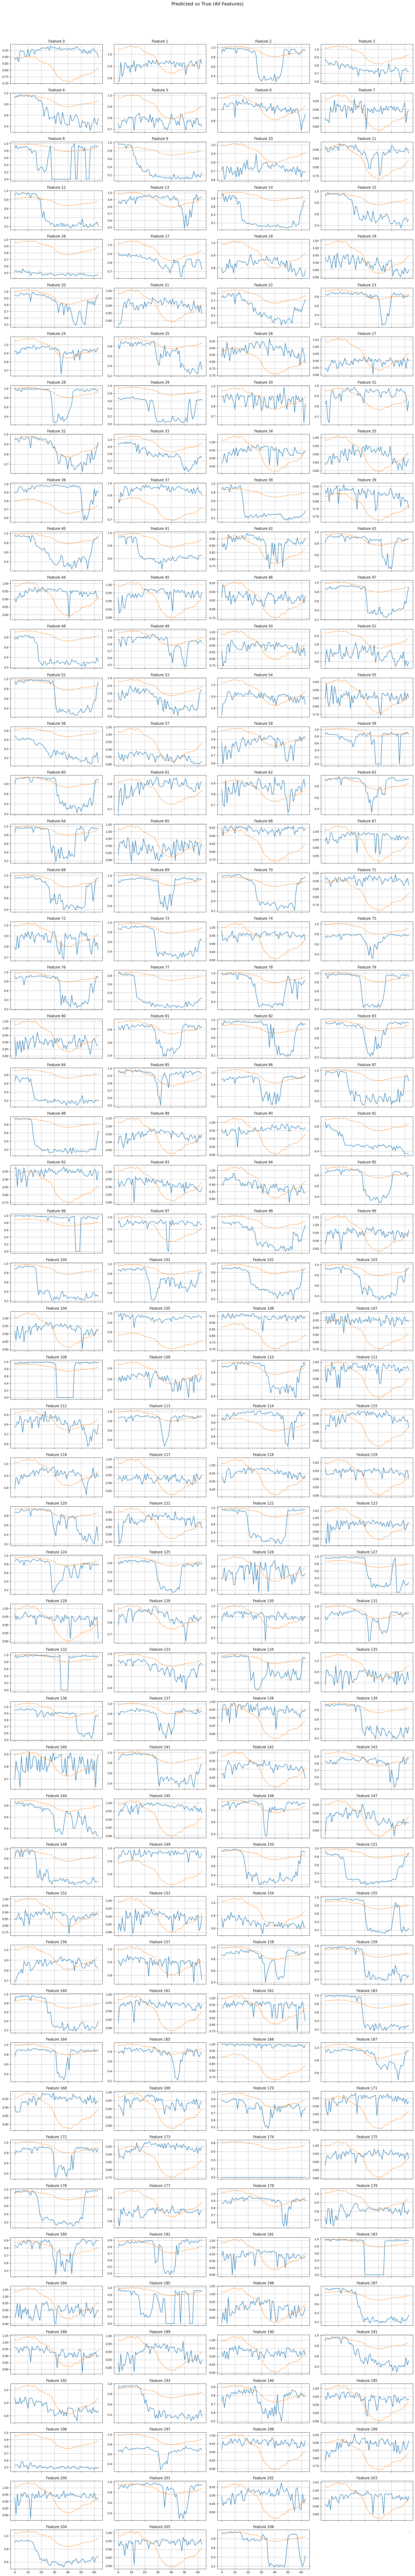

In [ ]:
plot_all_predictions(model, test_loader)
